In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
import string
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dotenv import load_dotenv
import os

import warnings
warnings.filterwarnings("ignore")

load_dotenv()
directory = os.getenv("path")

In [15]:
def ChangeExemplarsToBinary(datasetPath: str) -> pd.DataFrame:
    toBinary_df = pd.read_csv(datasetPath)
    toBinary_df = toBinary_df.iloc[:, 1:]

    for col in toBinary_df.columns:
        unique_values = toBinary_df[col].unique().tolist()
        toBinary_df[col] = toBinary_df.index.map(
            lambda x: 1 if x in unique_values else 0
        )

    return toBinary_df

# NOTE: uncomment the following lines to test the function:
# datasetPath = os.path.join(directory, "computed_data/ap_results", "func.csv")
# ChangeExemplarsToBinary(datasetPath)

In [16]:
def exemplarStabilityIndex(classification):
    """ the total number of time a station endorsed exemplarity per 10 years of classifications
    """
    
    df = ChangeExemplarsToBinary(classification)
    nameClass = classification.split("-")[1]
    df[f"sum_exemplars_{nameClass}"] = df.sum(axis=1)
    sum_list = df[f"sum_exemplars_{nameClass}"].to_list()
    return sum_list

In [ ]:
# NOTE: Dataframe with the sum of exemplars for each classification (Functional - F, Functional Climate - FC, Functional Climate Structural - FCS)    
func_df = exemplarStabilityIndex(os.path.join(directory, "computed_data/ap_results", "func.csv"))
func_climate_df = exemplarStabilityIndex(os.path.join(directory, "computed_data/ap_results", "func_climate.csv"))
func_climate_struct_df = exemplarStabilityIndex(os.path.join(directory, "computed_data/ap_results", "all_attributes.csv"))

df = pd.DataFrame({"F": func_df, "FC": func_climate_df, "FCS": func_climate_struct_df})
df["ALL"] = df.sum(axis=1)

df


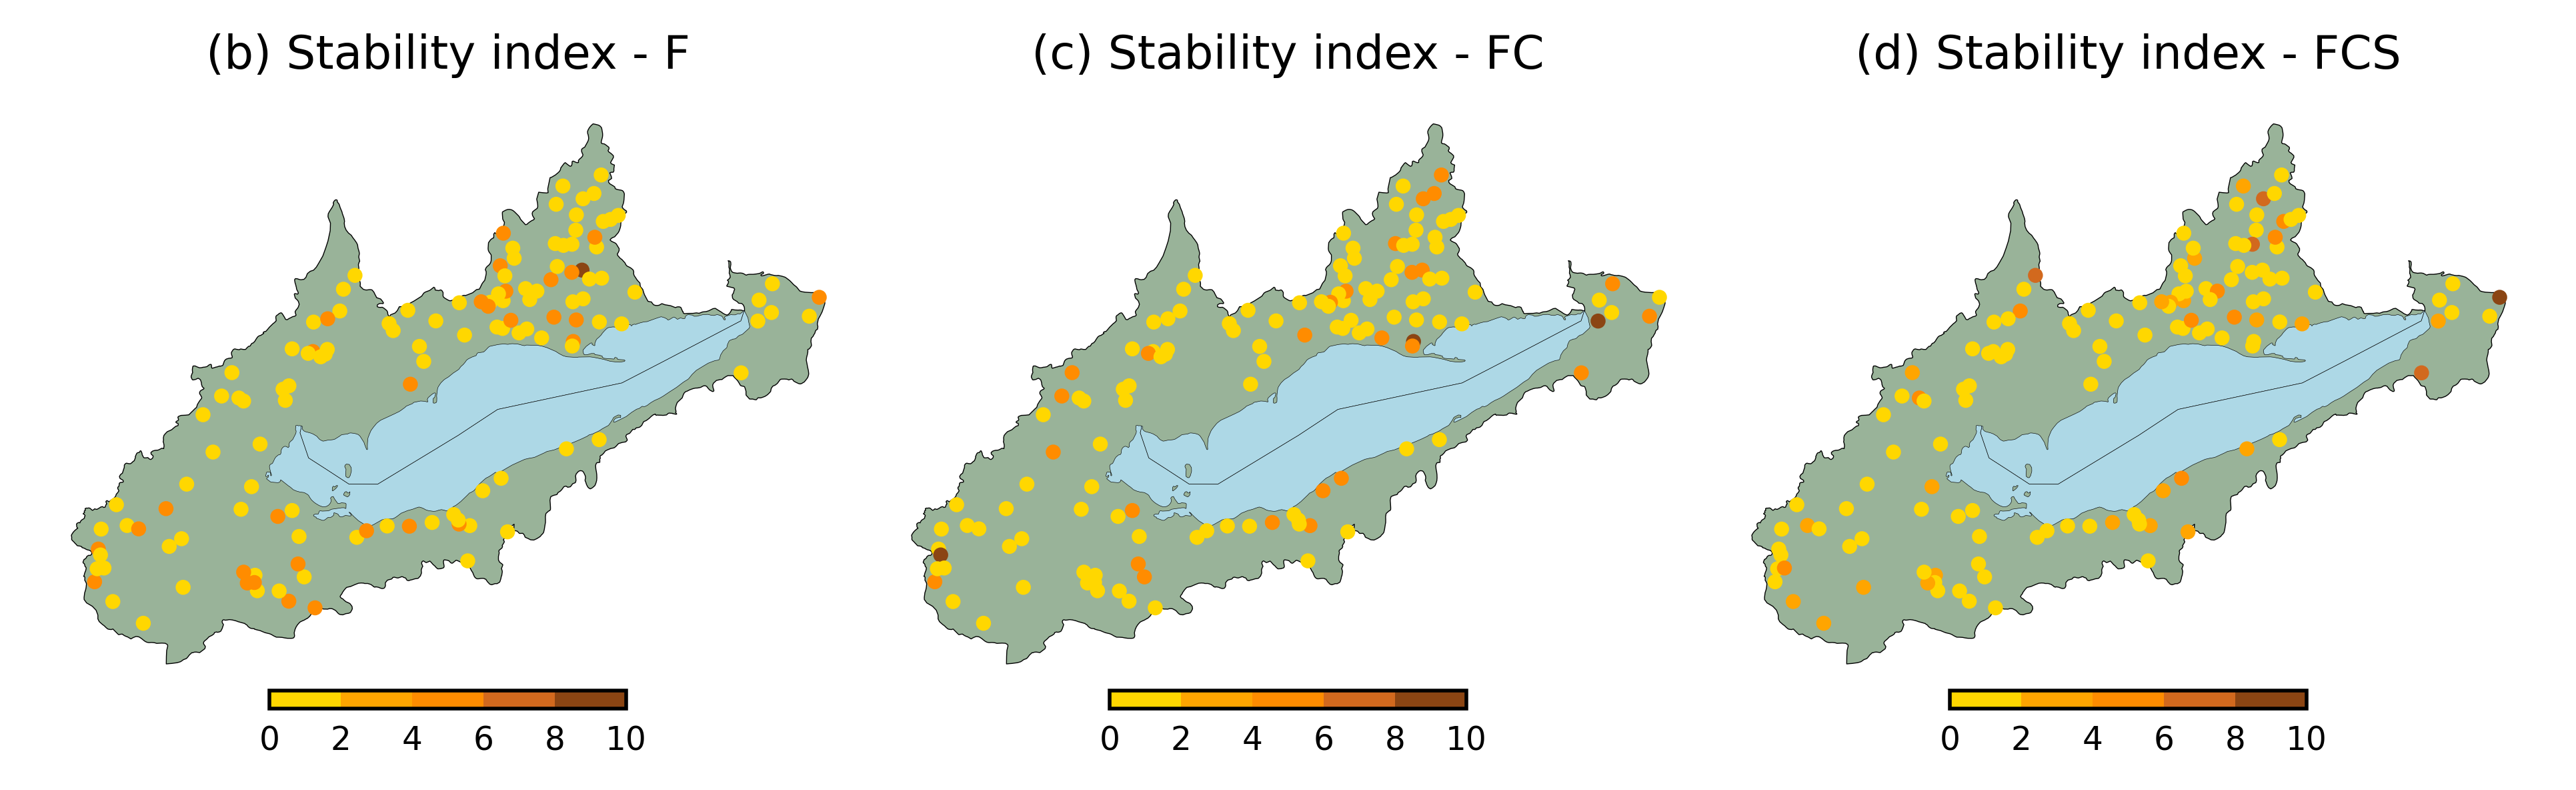

In [ ]:
stations_df = pd.read_csv(os.path.join(directory, "raw_data", "stations_list.csv"), index_col=0)
LEB_polygon = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "LakeErieBasinBoundaries.shp"))
Lake = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "LakeErie.shp"))
st_clair = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "hydro_p_LakeStClair", "hydro_p_LakeStClair.shp"))


binary_cvq_df = df.applymap(lambda x: 1 if x <2 else
                                                    (2 if (x >= 2) & (x<4)  else
                                                     (3 if (x >= 4) & (x<6)  else
                                                    (4 if (x >= 6)  & (x<8)else
                                                     5))))

gpd_stability = gpd.GeoDataFrame(binary_cvq_df, geometry=gpd.points_from_xy(stations_df.longitude, stations_df.latitude))
gpd_stability.set_crs(epsg=4326, inplace=True)

columnsP = gpd_stability.columns.to_list()[:-2]


f, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 6), linewidth=0, edgecolor='black', dpi=500)
axs = axs.flatten()

colors = ['gold', 'orange', 'darkorange', 'chocolate','saddlebrown']
cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=0, vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

labels_columns =  ["F", "FC", "FCS"]

for i, col in enumerate(columnsP):
    ax = axs[i]
    ax.set_aspect('auto')

    LEB_polygon.to_crs(epsg=4326).plot(ax=ax, color=(0.6, 0.7, 0.6),edgecolor="black", linewidth=0.2, markersize=1000)
    Lake.to_crs(epsg=4326).plot(ax=ax, color='lightblue',edgecolor="black", linewidth=0.09, markersize=1000)

    gpd_stability.plot(column = col, ax=ax,
            legend = False, markersize = 5, cmap=cmap)
    
    
    ax.set_axis_off()

    title_str = f"({string.ascii_lowercase[i+1]}) Stability index - {labels_columns[i]}"
    ax.set_title(title_str, size=10)
    ax.tick_params(labelsize=1)

  # Create a new axis for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="3%", pad=0, aspect = 0.5)
    cbar = f.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks(np.linspace(0, 10, 6))
    cbar.ax.tick_params(labelsize=7)
    cbar.ax.tick_params(size=0)



def format_tick(x, pos):
        return int(x)

plt.subplots_adjust(hspace=-.4, wspace=-0.25, left = 0, right =.7, top = 1.3, bottom = 0)


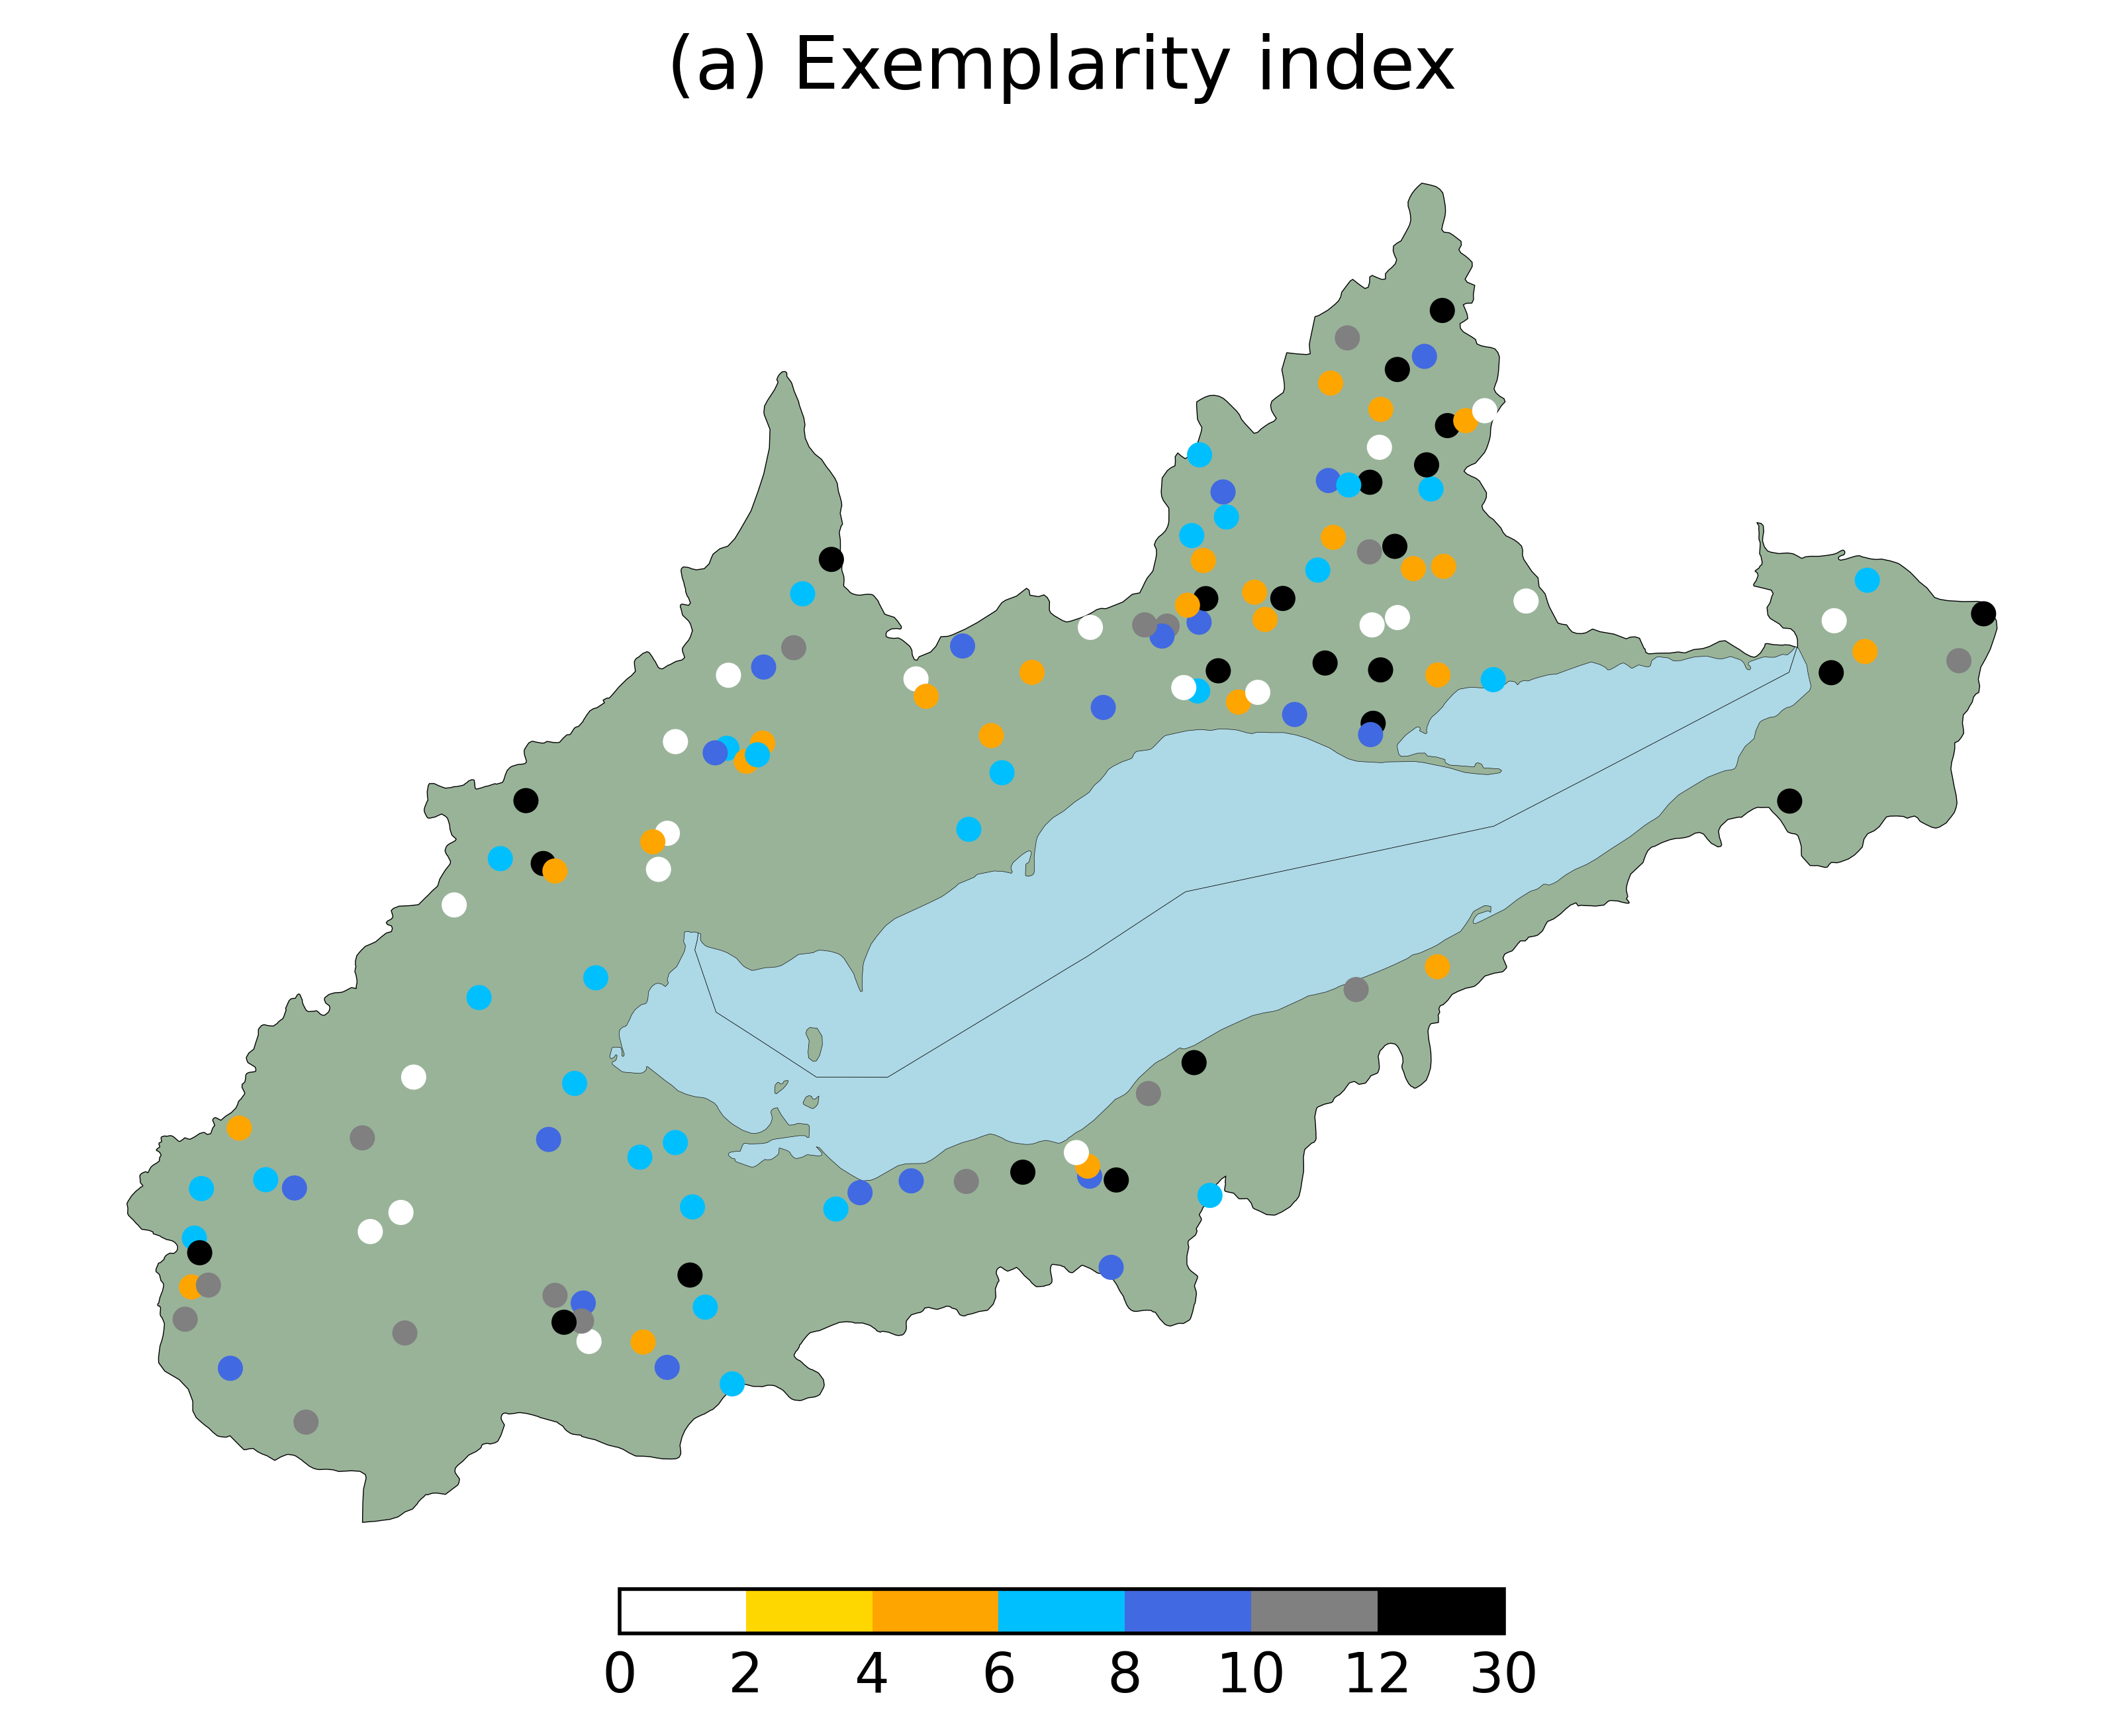

In [19]:
# NOTE: exemplarity (across different types of classification) figure:
stations_df = pd.read_csv(os.path.join(directory, "raw_data", "stations_list.csv"), index_col=0)
LEB_polygon = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "LakeErieBasinBoundaries.shp"))
Lake = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "LakeErie.shp"))
st_clair = gpd.read_file(os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "hydro_p_LakeStClair", "hydro_p_LakeStClair.shp"))


df_all = df.copy()
df_all["ALL"] = df_all.sum(axis=1)

exemplarity = df_all["ALL"]


exemplarity_binary_df = exemplarity.map(lambda x: 1 if x == 0 else
                                                    (2 if x == 1 else
                                                    (3 if (x >= 2) & (x < 4) else
                                                     (4 if (x >= 4) & (x < 6) else
                                                    (5 if (x >= 6) & (x < 8) else
                                                     (6 if (x >= 8) & (x < 10) else
                                                     7)))))).to_frame("ALL")

gpd_exemplarity = gpd.GeoDataFrame(exemplarity_binary_df, geometry=gpd.points_from_xy(stations_df.longitude, stations_df.latitude))
gpd_exemplarity.set_crs(epsg=4326, inplace=True)

columnsP = gpd_exemplarity.columns.to_list()[:-1]


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), linewidth=0, edgecolor='black', dpi=500)

# Define colors
colors = ['white', 'gold', 'orange', 'deepskyblue','royalblue','gray', 'black']


# Create color map and normalization
cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=0, vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Set labels for the title
labels_columns = ["Exemplarity index"]

# Plot the data
ax.set_aspect('auto')

# Example plot for polygons
LEB_polygon.to_crs(epsg=4326).plot(ax=ax, color=(0.6, 0.7, 0.6), edgecolor="black", linewidth=0.2, markersize=1000)
Lake.to_crs(epsg=4326).plot(ax=ax, color='lightblue', edgecolor="black", linewidth=0.09, markersize=1000)

gpd_exemplarity.plot(column='ALL', ax=ax, legend=False, markersize=20, cmap=cmap)

ax.set_axis_off()

# Add title
ax.set_title(f"(a) {labels_columns[0]}", size=16)


divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0, aspect=0.5)

# Define the tick positions and labels
tick_positions = np.linspace(0, 10, 8) 
tick_labels = [0, 2, 4, 6, 8, 10, 12, 30]

cbar = f.colorbar(sm, cax=cax, orientation='horizontal')

# Set the ticks and labels on the colorbar
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

# Optionally, you can adjust the tick size and label size
cbar.ax.tick_params(size=0, labelsize=12)

# Adjust plot layout
plt.subplots_adjust(hspace=-.4, wspace=-0.25, left=0, right=0.7, top=1.3, bottom=0)

plt.show()